In [516]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from natsort import natsorted
from scipy.optimize import dual_annealing
# from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
# from statsmodels.tsa.stattools import acf
import pickle
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
# from skimage.feature import ORB
import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy import optimize
import pickle
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread
import sys
from util_funcs import *

In [517]:

def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN].copy()
        # PHASE
        coords = phase_cross_correlation(min_max(data[i][UP:DOWN][:,:])
                                        ,min_max(temp_img[:,:])
                                        ,normalization=None,upsample_factor=20)[0]
        if np.abs(coords[0])<=30:
            temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=3)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # # ANTS
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN][:,:]),min_max(temp_img[:,:]))[0])
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN]),min_max(data[i+1][UP:DOWN]))[0])
        # if np.abs(mat['AffineTransform_float_2_2'][-2:][0][0])<=1000:
        #     tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all


# 5woWT

In [3]:
scan_num = '5woWT'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:06, 79.13it/s]


In [4]:
pics_without_line = pics_without_line[:,np.r_[1200:2200,6000:6900]]

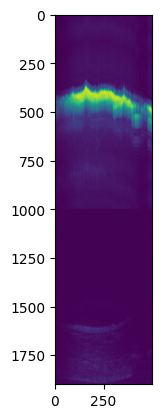

In [5]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [6]:
mid = 1000
UP,DOWN = 250,600
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:07<00:00, 66.41it/s]


In [7]:
# n = pics_without_line.shape[1]
# # nn = [np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)) for i in range(pics_without_line.shape[0])]
# nn = [np.argmax(np.sum(pics_without_line[i][500:800],axis=1)) for i in range(pics_without_line.shape[0])]
# mid = 1000
# tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
# for i in range(tf_all_nn.shape[0]):
#     tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

In [8]:
mid = 1000
UP,DOWN = 1500,1700
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:07<00:00, 71.43it/s]


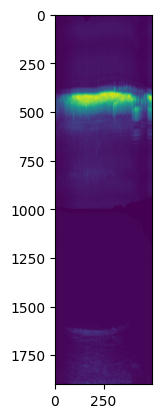

In [9]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [10]:
# nn = [np.argmax(np.sum(pics_without_line[i][1500:1700],axis=1)) for i in range(pics_without_line.shape[0])]
# mid = 1000
# tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
# for i in range(tf_all_nn.shape[0]):
#     tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tf_all_nn[i]),order=3)

In [11]:
# plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))
# nn = [np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)) for i in range(pics_without_line.shape[0])]
# UP, DOWN = np.min(nn)-80,np.max(nn)+80

In [12]:
# tr_all = ants_all_trans(pics_without_line,UP,DOWN)
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

In [13]:
# plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0)[1500:1700])

In [14]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(pics_without_line)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))

500it [00:09, 50.16it/s]


# 5woFECD

In [15]:
scan_num = '5woFECD'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:02, 206.28it/s]


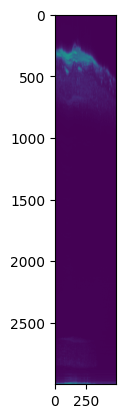

In [16]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [17]:
pics_without_line = pics_without_line[:,np.r_[:1000,2500:2900]]

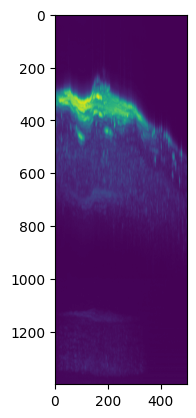

In [18]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [19]:
mid = 800
UP,DOWN = 200,600
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:05<00:00, 85.56it/s]


In [20]:
# n = pics_without_line.shape[1]
# # nn = [np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)) for i in range(pics_without_line.shape[0])]
# nn = [np.argmax(np.sum(pics_without_line[i][200:600],axis=1)) for i in range(pics_without_line.shape[0])]
# mid = 800
# tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
# for i in range(tf_all_nn.shape[0]):
#     tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

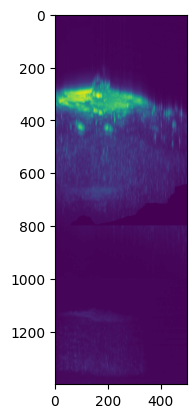

In [21]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [22]:
# nn = [np.argmax(np.sum(pics_without_line[i][1000:1250],axis=1)) for i in range(pics_without_line.shape[0])]
# mid = 800
# tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
# for i in range(tf_all_nn.shape[0]):
#     tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tf_all_nn[i]),order=3)

mid = 800
UP,DOWN = 1000,1250
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:04<00:00, 121.42it/s]


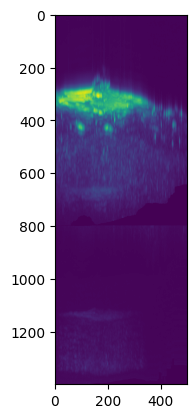

In [23]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [24]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(pics_without_line)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))

500it [00:06, 71.96it/s]


# 16woWT

In [25]:
scan_num = '16woWT'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 250.43it/s]


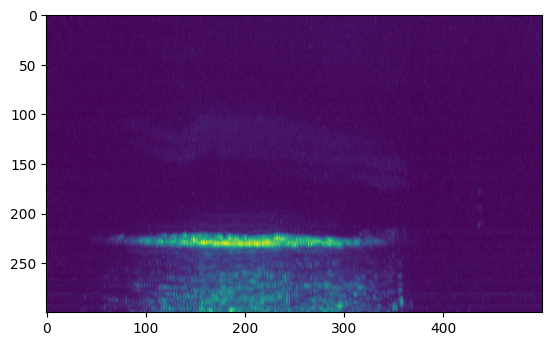

In [26]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0)[2100:2400])

In [27]:
pics_without_line = pics_without_line[:,np.r_[250:750,2100:2400]]

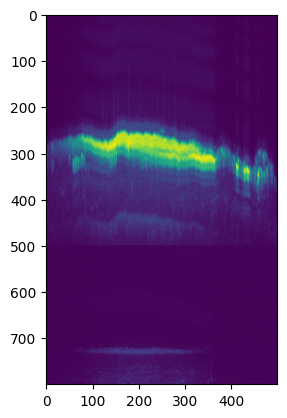

In [28]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [29]:
mid = 500
UP,DOWN = 200,420
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:03<00:00, 148.47it/s]


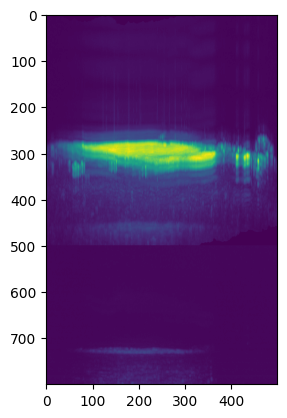

In [30]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [31]:
mid = 500
UP,DOWN = 650,800
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:02<00:00, 248.55it/s]


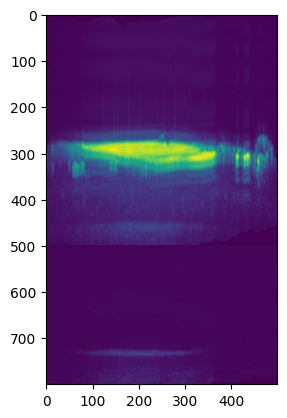

In [32]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [33]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(pics_without_line)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))

500it [00:03, 129.40it/s]


# 16woFECD

In [34]:
scan_num = '16woFECD'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 259.45it/s]


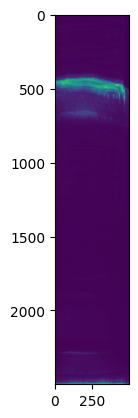

In [35]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [36]:
pics_without_line = pics_without_line[:,np.r_[200:900,2100:2400]]

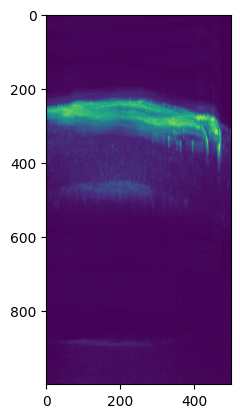

In [37]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [38]:
mid = 600
UP,DOWN = 190,420
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:04<00:00, 122.61it/s]


In [39]:
mid = 600
UP,DOWN = 800,1000
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:02<00:00, 183.63it/s]


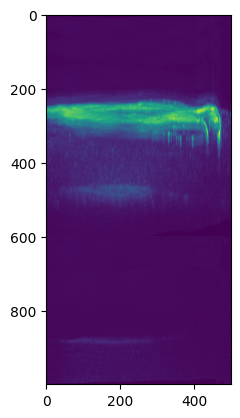

In [40]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [41]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(pics_without_line)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))

500it [00:04, 106.43it/s]


# pic3

In [527]:
scan_num = 'pic3'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
# pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 374.31it/s]


In [528]:
def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',
                        aff_iterations=(1100, 1200, 500, 500))
    return reg['fwdtransforms']

def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN].copy()
        # PHASE
        coords = phase_cross_correlation((data[i][UP:DOWN][:,:50])
                                        ,(temp_img[:,:50])
                                        ,normalization=None,upsample_factor=15)[0]
        if np.abs(coords[0])<=30:
            # temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=0)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # ANTS
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN][:,:50]),min_max(temp_img[:,:50]))[0])
        # # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN]),min_max(data[i+1][UP:DOWN]))[0])
        # if np.abs(mat['AffineTransform_float_2_2'][-2:][0][0])<=5:
        #     tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all


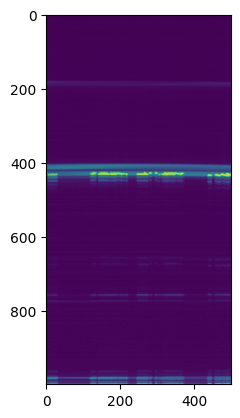

In [529]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [530]:
pics_without_line = pics_without_line[:,np.r_[350:800]]

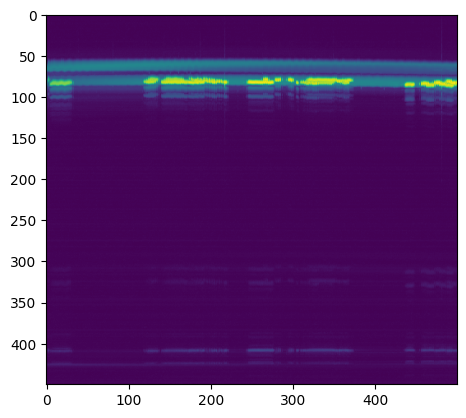

In [531]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [532]:
mid = 200
UP,DOWN = 20,120
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:01<00:00, 316.08it/s]


In [533]:
mid = 200
UP,DOWN = 380,454
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:02<00:00, 242.97it/s]


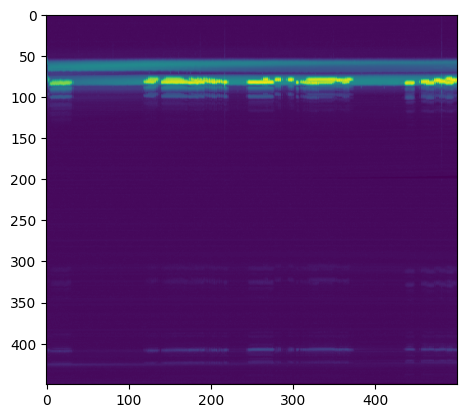

In [534]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [627]:
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(shif[0],0))
    warped = warp(y, tform,order=3)
    return 1-ncc(x,warped)

def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation')
    return reg['fwdtransforms']

def thresh(data):
    return data*(data>threshold_otsu(data))

transforms_all = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
UP,DOWN = 50,100
all_ncc = []
for i in tqdm(range(5,pics_without_line.shape[0]-1)):
    coords = phase_cross_correlation(thresh(pics_without_line[i][UP:DOWN])
                                    ,thresh(pics_without_line[i+1][UP:DOWN])
                                    ,normalization=None,upsample_factor=15)
    tff = AffineTransform(translation = (-coords[0][1],0))
    err = 1-ncc((pics_without_line[i][UP:DOWN])
                ,(pics_without_line[i+1][UP:DOWN]))
    # err = coords[1]
    if np.abs(coords[0][1])<2:
        transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    all_ncc.append(err)

    temp_tform_manual = AffineTransform(translation=(0,0))
    temp_manual = pics_without_line[i+1][UP:DOWN].copy()
    for _ in range(5):
        move = minz(method='nelder-mead',fun = mse_fun_tran,x0 =(0),
                    args = (thresh(pics_without_line[i][UP:DOWN])
                            ,thresh(temp_manual)))['x']
        temp_transform = AffineTransform(translation=(move[0],0))
        temp_manual = warp(temp_manual, temp_transform,order=3)
        temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
    temp_tform_manual = AffineTransform(matrix = temp_tform_manual)
    err = 1-ncc((pics_without_line[i][UP:DOWN])
                ,(pics_without_line[i+1][UP:DOWN]))
    if np.abs(np.array(temp_tform_manual)[0,2])<=2:
        # temp_img = warp(temp_img,temp_tform_manual,order=3)
        transforms_all[i+1:] = np.dot(transforms_all[i+1:],(temp_tform_manual))
    all_ncc.append(err)

    # mat = scipy.io.loadmat(ants_reg_mapping((pics_without_line[i][UP:DOWN])
    #                                         ,(pics_without_line[i+1][UP:DOWN]))[0])
    # tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))

    # err = 1-ncc((pics_without_line[i][np.r_[UP:DOWN]])
    #                     ,(warp(pics_without_line[i+1][np.r_[UP:DOWN]], tff,order=3)))
    # if err<0.006:
    #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    # all_ncc.append(err)



100%|██████████| 494/494 [01:40<00:00,  4.90it/s]


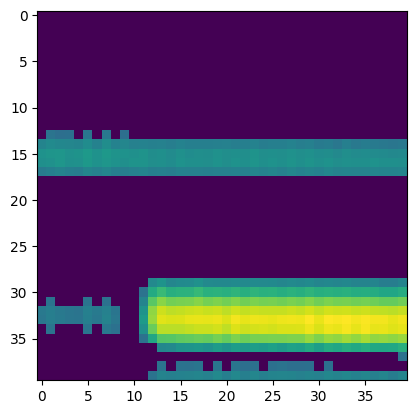

In [628]:
plt.imshow((pics_without_line[21][50:90,300:340]*((pics_without_line[21][50:90,300:340]>170.4))))

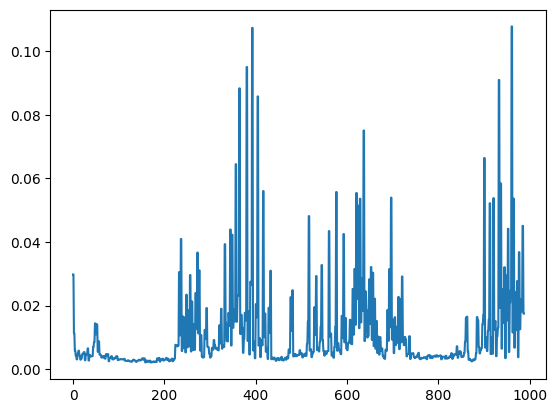

In [629]:
plt.plot(all_ncc)


In [630]:
gg = pics_without_line.copy()
# warp the images
for i in tqdm(range(gg.shape[0])):
    gg[i] = warp(gg[i],AffineTransform(matrix=transforms_all[i]),order=3)


100%|██████████| 500/500 [00:03<00:00, 158.48it/s]


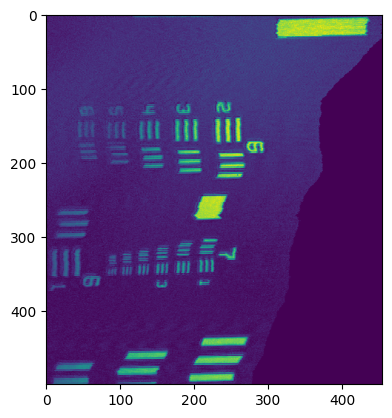

In [631]:
plt.imshow((gg.transpose(1,0,2)[100]))

In [515]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
gg = min_max(gg)
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',((j)*((2**16)-1)).astype(np.uint16))

500it [00:01, 252.36it/s]


# scan33

In [518]:
scan_num = 'scan33'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
# pics_without_line = pics_without_line.astype(np.float32)

217it [00:00, 410.47it/s]
